# LightGBM

In [1]:
import pandas as pd
import numpy as np
import time, re, string
import warnings
from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm_notebook as tqdm

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100

## Load Train and Test Data with Derived Features

In [2]:
train = pd.read_csv('input/train_featv3.csv')
test = pd.read_csv('input/test_featv3.csv')
train.head()

,user_id,is_open,is_click,date,month,hour,mins,communication_type,total_links,no_of_internal_links,no_of_images,no_of_sections,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_stopwords,mean_word_len,word_unique_percent,punct_percent,email_count_word,email_count_unique_word,email_count_letters,email_count_punctuations,email_cap_count,day_of_week,count_click,count_user,click_confidence,count_is_open,is_open_confidence,email_3_similar,sub_3_similar,campaign_id,sub_period,comm_type_click_percent,body_polarity,title_polarity,body_subjectivity,title_subjectivity
0,14051,0,0,1,9,19,55,3,88.0,79.0,13.0,4.0,1.0,12.0,12.0,88.0,5.0,2.0,6.416667,100.0,41.666667,238.0,159.0,1382.0,37.0,58.0,4,0.0,9.0,0.0,0.0,0.0,0.0,2.0,42,247,12.70333,0.278346,0.462500,0.644388,0.650000
1,134438,0,0,2,11,12,53,3,67.0,62.0,10.0,4.0,1.0,16.0,16.0,111.0,5.0,3.0,6.000000,100.0,31.250000,166.0,122.0,971.0,24.0,48.0,3,0.0,4.0,0.0,0.0,0.0,1.0,2.0,52,150,12.70333,0.071053,0.170455,0.376754,0.454545
2,181789,0,0,24,7,15,15,4,7.0,3.0,1.0,1.0,1.0,12.0,12.0,71.0,3.0,1.0,5.000000,100.0,25.000000,118.0,92.0,739.0,28.0,42.0,0,0.0,7.0,0.0,0.0,0.0,1.0,1.0,33,249,14.27746,0.408333,0.000000,0.579365,0.000000
3,231448,0,0,5,9,11,36,5,60.0,56.0,19.0,6.0,1.0,10.0,10.0,73.0,3.0,2.0,6.400000,100.0,30.000000,43.0,38.0,273.0,9.0,9.0,1,0.0,6.0,0.0,0.0,0.0,1.0,1.0,44,216,13.02976,0.166667,0.000000,0.766667,0.000000
4,185580,0,0,1,7,18,1,3,67.0,61.0,12.0,3.0,1.0,11.0,11.0,55.0,2.0,3.0,4.090909,100.0,18.181818,243.0,176.0,1498.0,37.0,35.0,5,0.0,5.0,0.0,0.0,0.0,0.0,1.0,29,220,12.70333,0.390083,0.000000,0.588671,0.000000


In [3]:
train.columns

Index(['user_id', 'is_open', 'is_click', 'date', 'month', 'hour', 'mins',
       'communication_type', 'total_links', 'no_of_internal_links',
       'no_of_images', 'no_of_sections', 'count_sent', 'count_word',
       'count_unique_word', 'count_letters', 'count_punctuations',
       'count_stopwords', 'mean_word_len', 'word_unique_percent',
       'punct_percent', 'email_count_word', 'email_count_unique_word',
       'email_count_letters', 'email_count_punctuations', 'email_cap_count',
       'day_of_week', 'count_click', 'count_user', 'click_confidence',
       'count_is_open', 'is_open_confidence', 'email_3_similar',
       'sub_3_similar', 'campaign_id', 'sub_period', 'comm_type_click_percent',
       'body_polarity', 'title_polarity', 'body_subjectivity',
       'title_subjectivity'],
      dtype='object')

## Feature Engineering

- Date 
- Time (in minutes)
- Day of Week
- Communication Type
- Total Links
- No of Internal Links, No of Images
- Subject - Count of Sentences, Letters, Punctuations and Stopwords
- Subject - Unique Word Percentage
- Subject - Punctuation Percentage
- Email - Count of Word, Punctuation and Capital Letters
- Count Click
- Count User
- Click Confidence
- Count of People Opening the Mail
- Open Confidence
- Email Similarity, Subject Similarity
- Subscription Period
- Communication Type Click Percentage
- Count User Frequency
- Sentiment of Mail

In [4]:
train['time'] = train['hour']*60 + train['mins']
test['time'] = test['hour']*60 + test['mins']

In [5]:
Y_train = train['is_click'].values

cols = ['user_id', 'date', 'time', 'communication_type', 'total_links',  
        'no_of_internal_links', 'no_of_images', 'count_sent', 'count_letters', 'count_punctuations', 
        'count_stopwords', 'word_unique_percent', 'punct_percent', 'email_count_word', 
        'email_count_unique_word', 'email_count_punctuations', 'email_cap_count', 'day_of_week', 
        'count_click', 'count_user', 'click_confidence','count_is_open','is_open_confidence', 
        'body_polarity', 'title_polarity','body_subjectivity', 'title_subjectivity', 
        'email_3_similar', 'sub_3_similar', 'sub_period', 'comm_type_click_percent']

X_train = train[cols]
X_test = test[cols]

### Fill NaN values with mean 

In [6]:
## filled new user with click confidence of mean of first users ###
X_test['click_confidence'] = X_test['click_confidence'].fillna(0.0072169867589168555)
X_test['is_open_confidence'] = X_test['is_open_confidence'].fillna(0.10831444590242156)
X_test.loc[X_test['count_user'] == 0,'count_click'] = 0.0072169867589168555
X_test.loc[X_test['count_user'] == 0,'count_is_open'] = 0.10831444590242156
X_test.loc[X_test['count_user'] == 0,'count_user'] = 1

In [7]:
X_train.loc[:,'count_user_freq'] = (1/X_train.loc[:,'count_user'])
X_test.loc[:,'count_user_freq'] = (1/X_test.loc[:,'count_user'])

### Calculate Sentiment Score from Polarity and Subjectivity Scores

In [8]:
dropcols = ['body_polarity', 'title_polarity','body_subjectivity', 'title_subjectivity']
X_train.loc[:,'sentiment'] = X_train.loc[:,'body_polarity'] + X_train.loc[:,'title_polarity'] + X_train.loc[:,'body_subjectivity'] + X_train.loc[:,'title_subjectivity']
X_test.loc[:,'sentiment'] = X_test.loc[:,'body_polarity'] + X_test.loc[:,'title_polarity'] + X_test.loc[:,'body_subjectivity'] + X_test.loc[:,'title_subjectivity']
X_train.drop(dropcols,axis=1,inplace=True)
X_test.drop(dropcols,axis=1,inplace=True)

In [9]:
X_train.head()

,user_id,date,time,communication_type,total_links,no_of_internal_links,no_of_images,count_sent,count_letters,count_punctuations,count_stopwords,word_unique_percent,punct_percent,email_count_word,email_count_unique_word,email_count_punctuations,email_cap_count,day_of_week,count_click,count_user,click_confidence,count_is_open,is_open_confidence,email_3_similar,sub_3_similar,sub_period,comm_type_click_percent,count_user_freq,sentiment
0,14051,1,1195,3,88.0,79.0,13.0,1.0,88.0,5.0,2.0,100.0,41.666667,238.0,159.0,37.0,58.0,4,0.0,9.0,0.0,0.0,0.0,0.0,2.0,247,12.70333,0.111111,2.035234
1,134438,2,773,3,67.0,62.0,10.0,1.0,111.0,5.0,3.0,100.0,31.250000,166.0,122.0,24.0,48.0,3,0.0,4.0,0.0,0.0,0.0,1.0,2.0,150,12.70333,0.250000,1.072807
2,181789,24,915,4,7.0,3.0,1.0,1.0,71.0,3.0,1.0,100.0,25.000000,118.0,92.0,28.0,42.0,0,0.0,7.0,0.0,0.0,0.0,1.0,1.0,249,14.27746,0.142857,0.987698
3,231448,5,696,5,60.0,56.0,19.0,1.0,73.0,3.0,2.0,100.0,30.000000,43.0,38.0,9.0,9.0,1,0.0,6.0,0.0,0.0,0.0,1.0,1.0,216,13.02976,0.166667,0.933333
4,185580,1,1081,3,67.0,61.0,12.0,1.0,55.0,2.0,3.0,100.0,18.181818,243.0,176.0,37.0,35.0,5,0.0,5.0,0.0,0.0,0.0,0.0,1.0,220,12.70333,0.200000,0.978753


## Under Sampling using Repeated Edited Nearest Neighbour Algorithm

In [10]:
from imblearn.under_sampling import (AllKNN, EditedNearestNeighbours, RepeatedEditedNearestNeighbours)

print('RENN')
enn = RepeatedEditedNearestNeighbours(return_indices=True)
X_res, Y_res, idx_res = enn.fit_sample(X_train, Y_train)
reduction_str = ('Reduced {:.2f}%'.format(100 * (1 - float(len(X_res))/len(X_train))))
print(reduction_str)

RENN
Reduced 5.09%


In [11]:
print (X_res.shape, Y_res.shape)
print (Y_res.sum(), Y_train.sum())

(971083, 29) (971083,)
12782 12782


## Split Train-Validation Set

In [12]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import lightgbm as lgb

X_rs_trn, X_rs_val, Y_res_trn, Y_res_val = train_test_split(X_res, Y_res, test_size=0.075, shuffle=True
                                                            , random_state=42)

print ("Train_shape: " + str(X_rs_trn.shape))
print ("Val_shape: " + str(X_rs_val.shape))
print ("No of positives in train: " + str(Y_res_trn.sum()))
print ("No of positives in val: " + str(Y_res_val.sum()))

Train_shape: (898251, 29)
Val_shape: (72832, 29)
No of positives in train: 11776
No of positives in val: 1006


## Training the Model

In [13]:
lgb_train = lgb.Dataset(X_rs_trn, Y_res_trn)
lgb_eval = lgb.Dataset(X_rs_val, Y_res_val)
evals_result = {} 

params = {
    'task': 'train',
    'boosting_type': 'dart',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 11,
    'learning_rate': 0.01,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
}

print('Start training...')

gbm = lgb.train(params, lgb_train, num_boost_round=5000, valid_sets=lgb_eval, early_stopping_rounds=50, 
                evals_result=evals_result, verbose_eval=25)

Start training...
Training until validation scores don't improve for 50 rounds.
[25]	valid_0's auc: 0.979175
[50]	valid_0's auc: 0.979463
[75]	valid_0's auc: 0.979558
[100]	valid_0's auc: 0.979609
[125]	valid_0's auc: 0.97963
[150]	valid_0's auc: 0.979593
[175]	valid_0's auc: 0.979611
[200]	valid_0's auc: 0.979645
[225]	valid_0's auc: 0.979686
[250]	valid_0's auc: 0.97975
[275]	valid_0's auc: 0.979842
[300]	valid_0's auc: 0.979814
[325]	valid_0's auc: 0.979856
[350]	valid_0's auc: 0.97988
[375]	valid_0's auc: 0.9799
[400]	valid_0's auc: 0.979901
[425]	valid_0's auc: 0.97992
[450]	valid_0's auc: 0.979957
[475]	valid_0's auc: 0.97997
[500]	valid_0's auc: 0.97997
[525]	valid_0's auc: 0.97999
[550]	valid_0's auc: 0.980003
[575]	valid_0's auc: 0.980003
[600]	valid_0's auc: 0.980003
[625]	valid_0's auc: 0.980004
[650]	valid_0's auc: 0.980014
[675]	valid_0's auc: 0.980046
[700]	valid_0's auc: 0.980056
[725]	valid_0's auc: 0.98007
[750]	valid_0's auc: 0.980094
[775]	valid_0's auc: 0.980091
[80

### Plot Training AUC

Plot metrics during training...


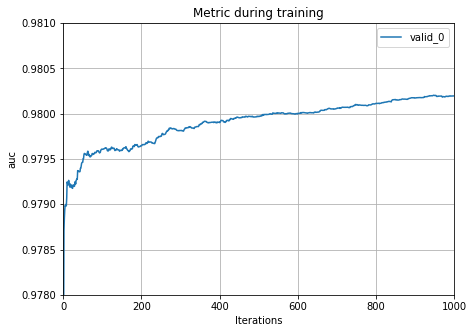

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='auc', ylim=(0.978, 0.981), figsize=(7, 5))
plt.show()

### Plot Feature Importance

Plot feature importances...


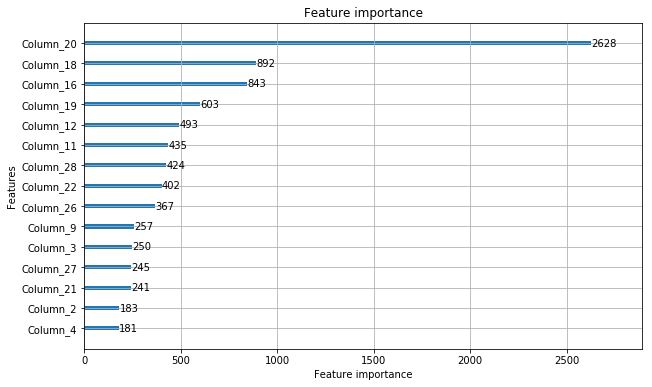

In [23]:
print('Plot feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=15, figsize=(10, 6))
plt.show()

## Predicting on Test Data

In [24]:
print('Start predicting...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

Start predicting...


In [25]:
sub = pd.read_csv('input/sample_submission.csv')
sub['is_click'] = y_pred
sub.head()

,id,is_click
0,63_122715,0.036591
1,56_76206,0.036477
2,57_96189,0.040912
3,56_166917,0.036401
4,56_172838,0.041053


In [26]:
sub.to_csv('sub_lgbm.csv', index=False)

## Output Distribution

In [27]:
sub.describe()

,is_click
count,773858.000000
mean,0.082196
std,0.079803
min,0.036294
25%,0.036402
50%,0.036774
75%,0.152516
max,0.844872


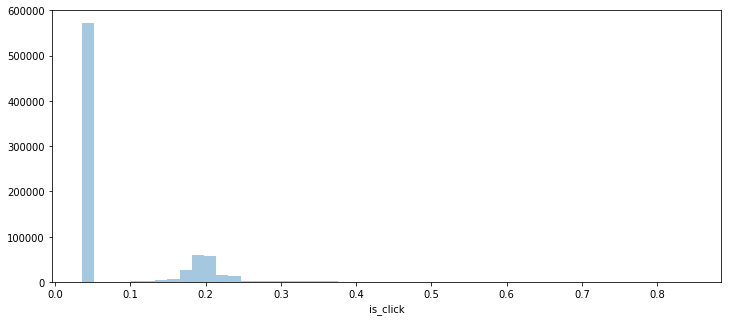

In [31]:
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.distplot(sub['is_click'], kde = False)

## AV Leaderboard Score - 0.68173

## Final Solution is an ensemble of LightGBM and XGBoost
### Final Score - 0.68799

## Private LB - 0.68630